### Group Project 4 : Comparing 3 Models for Predicting Recidivism

For background on this project, please see the [README](../README.md).

**Notebooks**
- [Data Acquisition & Cleaning](./01_data_acq_clean.ipynb)
- [Exploratory Data Analysis](./02_eda.ipynb)
- Modeling (this notebook)
- [Model Tuning](./04_tuning.ipynb)
- [Experiments](./04a_experiments.ipynb)
- [Results and Recommendations](./05_results.ipynb)

**In this notebook, you'll find:**
- Classification models for each of the 3 datasets
- TODO etc.

**Model 1: Base feature set - New York**

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, StackingClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras import utils
from tensorflow.keras.datasets import mnist
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

from imblearn.under_sampling import RandomUnderSampler, NearMiss
from imblearn.over_sampling import RandomOverSampler, ADASYN
from sklearn.metrics import balanced_accuracy_score, ConfusionMatrixDisplay, recall_score, f1_score, precision_score
from imblearn.pipeline import Pipeline as ImbalancedPipeline
from sklearn.decomposition import PCA

**Model 1: Base feature set - New York**

In [85]:
%store -r ny_df

In [86]:
#Define X and y, Train Test and Split the Data

X = ny_df[['gender_map', 'Age at Release']]
y = ny_df['recidivism']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

##### Basic Models- Two Features Gender and Age

In [87]:
#Logistic Regression, Instantiate and Fit Model
lr = LogisticRegression()
lr.fit(X_train, y_train)

#Save train and test accuracy for model evaluation
log_train = lr.score(X_train, y_train)
log_test = lr.score(X_test, y_test)

In [88]:
#Random Forest, Instantiate and Fit
rf= RandomForestClassifier(random_state = 42)
rf.fit(X_train, y_train)

#Save train and test accuracy for model eval
rf_train = rf.score(X_train, y_train)
rf_test = rf.score(X_test, y_test)

In [89]:
#Ada Boost
ada= AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 42))
ada.fit(X_train, y_train)

ada_train = ada.score(X_train, y_train)
ada_test = ada.score(X_test, y_test)

In [90]:
#Gradient Boost
gboost= GradientBoostingClassifier(random_state = 42)
gboost.fit(X_train, y_train)

gb_train = gboost.score(X_train, y_train)
gb_test = gboost.score(X_test, y_test)

In [91]:
#Stacked Model
level1_estimators = [
    ('random_forest', RandomForestClassifier()),
    ('gboost', GradientBoostingClassifier()),
    ('ada', AdaBoostClassifier())
]

stacked_model = StackingClassifier(estimators=level1_estimators,
                                 final_estimator = LogisticRegression())

stacked_model.fit(X_train, y_train)

#Save train and test accuracy for model eval
stack_train = stacked_model.score(X_train, y_train)
stack_test = stacked_model.score(X_test, y_test)

In [92]:
#KNN
ss = StandardScaler()
X_train_sc=ss.fit_transform(X_train)
X_test_sc= ss.transform(X_test)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

#Save train and test accuracy for model eval
knn_train = knn.score(X_train, y_train)
knn_test = knn.score(X_test, y_test)

##### Models Including County, Gender, Age

In [93]:
#Creating a Dataframe including dummies of the county of indictment
df_dummies = pd.get_dummies(ny_df['County of Indictment'])
df_dummies['gender'] = ny_df['gender_map']
df_dummies['recidivism'] = ny_df['recidivism']
df_dummies['age'] = ny_df['Age at Release']

#Define X and y with dummy data
X = df_dummies.drop(columns = ['recidivism'])
y = df_dummies['recidivism']

#Train test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, random_state =42, stratify = y)

In [94]:
#Logistic Regression Model
lr2 = LogisticRegression()
lr2.fit(X_train2, y_train2)

#Storing Accuracy Scores
log_train2 = lr2.score(X_train2, y_train2)
log_test2 = lr2.score(X_test2, y_test2)

c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [95]:
#Random Forest with Hyperparameter tuning
rf2= RandomForestClassifier(random_state = 42)
rf_params = {
    'n_estimators': [120, 130],
    'max_depth': [15,20],
    'max_features' : [15,20],
    'n_jobs': [-1]
}

gs1 = GridSearchCV(rf, param_grid= rf_params, cv = 3, n_jobs = -1)

gs1.fit(X_train2, y_train2)

#Storing Accuracy Scores
rf_train2 = gs1.score(X_train2, y_train2)
rf_test2 = gs1.score(X_test2, y_test2)

In [96]:
#Ada Boost with Hyperparam tuning
ada= AdaBoostClassifier(base_estimator = DecisionTreeClassifier(random_state = 42))

ada_params= {
    'n_estimators': [50, 100],
    'base_estimator__max_depth':[1,3]
}

gs2 = GridSearchCV(ada, param_grid = ada_params, cv = 3, n_jobs = -1)
gs2.fit(X_train2, y_train2)

#Storing Accuracy Scores
ada_train2 = gs2.score(X_train2, y_train2)
ada_test2 = gs2.score(X_test2, y_test2)

In [97]:
#Graident Boost
gboost2= GradientBoostingClassifier(random_state = 42)

gboost2.fit(X_train2, y_train2)


#Storing Accuracy Scores
gboost_train2 = gboost2.score(X_train2, y_train2)
gboost_test2 = gboost2.score(X_test2, y_test2)

In [98]:
#Stacked Model
level1_estimators = [
    ('random_forest', RandomForestClassifier()),
    ('gboost', GradientBoostingClassifier())
]

stacked_model2 = StackingClassifier(estimators=level1_estimators,
                                 final_estimator = LogisticRegression())

stacked_model2.fit(X_train2, y_train2)

#Storing Accuracy Scores
stack_train2 = stacked_model2.score(X_train2, y_train2)
stack_test2 = stacked_model2.score(X_test2, y_test2)

In [99]:
X_train2.shape

(141487, 65)

In [100]:
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train2)
X_test_sc = ss.transform(X_test2)

In [101]:
# Instantiate a CNN.
model = Sequential()

model.add(Dense(84, input_shape = (65,), activation = 'relu'))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

# Compile it
model.compile(loss = 'bce', optimizer = 'adam', metrics = ['accuracy'])

# Fit it
res = model.fit(X_train_sc, y_train2,
                epochs = 10,
                batch_size = 32,
                validation_data = (X_test_sc, y_test2),
                verbose = 0) # No printing of our output

In [102]:
#Save Accuracy Scores
train_loss = res.history['accuracy']
test_loss = res.history['val_accuracy']

neuralnet_train = max(train_loss)
neuralnet_test = max(test_loss)

##### Model Evaluation

In [103]:
#Model Evaluation No Dummies
train_scores = [log_train, rf_train, ada_train, gb_train, stack_train, knn_train]
eval_df = pd.DataFrame(train_scores, columns = ['train_scores'])

eval_df['test_scores'] = [log_test, rf_test, ada_test, gb_test, stack_test, knn_test]
eval_df.index = ['logreg', 'rf', 'ada', 'gb', 'stack', 'knn']
eval_df['diff'] = eval_df['train_scores'] - eval_df['test_scores']
eval_df['baseline'] = .58

eval_df

,train_scores,test_scores,diff,baseline
logreg,0.586831,0.587728,-0.000896,0.58
rf,0.588386,0.587070,0.001316,0.58
ada,0.588386,0.587113,0.001273,0.58
gb,0.588386,0.587070,0.001316,0.58
stack,0.588386,0.587070,0.001316,0.58
knn,0.534304,0.534614,-0.000310,0.58


In [104]:
#Model Evaluation With Dummies
train_scores2 = [log_train2, rf_train2, ada_train2, gboost_train2, stack_train2, neuralnet_train]
eval_df2 = pd.DataFrame(train_scores2, columns = ['train_scores'])

eval_df2['test_scores'] = [log_test2, rf_test2, ada_test2, gboost_test2, stack_test2, neuralnet_test]
eval_df2.index = ['logreg', 'rf', 'ada', 'gb', 'stack', 'neuralnet']
eval_df2['diff'] = eval_df2['train_scores'] - eval_df2['test_scores']
eval_df2['baseline'] = .58

eval_df2

,train_scores,test_scores,diff,baseline
logreg,0.598642,0.599665,-0.001023,0.58
rf,0.603236,0.597714,0.005521,0.58
ada,0.599362,0.599220,0.000143,0.58
gb,0.598988,0.598711,0.000277,0.58
stack,0.601122,0.600153,0.000970,0.58
neuralnet,0.599136,0.599050,0.000086,0.58


**Model 2: Criminal history feature set - Florida**

In [105]:
# read in clean dataset
fl = pd.read_csv('../data/FL/FL_final.csv')
fl.columns

Index(['person_id', 'num_incarcerations', 'comp_f_min_score',
       'comp_f_min_decile', 'comp_f_max_score', 'comp_f_max_decile',
       'comp_r_min_score', 'comp_r_min_decile', 'comp_r_max_score',
       'comp_r_max_decile', 'comp_v_min_score', 'comp_v_min_decile',
       'comp_v_max_score', 'comp_v_max_decile', 'sex_Male', 'race_Asian',
       'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other',
       'charge_degree_count_F1', 'charge_degree_count_F2',
       'charge_degree_count_F3', 'charge_degree_count_F5',
       'charge_degree_count_F6', 'charge_degree_count_F7',
       'charge_degree_count_M1', 'charge_degree_count_M2',
       'charge_degree_count_M3', 'agg_charges', 'avg_days_between_offenses',
       'avg_days_between_arrests', 'first_charge_degree_F1',
       'first_charge_degree_F2', 'first_charge_degree_F3',
       'first_charge_degree_F5', 'first_charge_degree_F6',
       'first_charge_degree_F7', 'first_charge_degree_M1',
       'first_charge_degree

CONCLUSIONS
- We should drop all columns that were used only for EDA and will not be considered for the model.
- We should also check the distribution of our target class to determine whether any rebalancing is needed.

In [106]:
# drop all non-model columns
fl = fl.drop(columns = [
    'person_id',  # unique ID, not predictive
    'agg_charges', # will be used for NLP experiment
    'avg_days_between_offenses', 'avg_days_between_arrests', # only meaningful for recidivists
    'age_at_last_incarceration', 'age_at_last_release', 'age_at_last_arrest', # "last" columns are not predictive
] + [col for col in fl if col.startswith('comp_')] # not using COMPAS scores in the model
  + [col for col in fl if col.startswith('last_charge_')] # last charges are not predictive
)

In [107]:
fl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10645 entries, 0 to 10644
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   num_incarcerations              10645 non-null  int64  
 1   sex_Male                        10645 non-null  int64  
 2   race_Asian                      10645 non-null  int64  
 3   race_Caucasian                  10645 non-null  int64  
 4   race_Hispanic                   10645 non-null  int64  
 5   race_Native American            10645 non-null  int64  
 6   race_Other                      10645 non-null  int64  
 7   charge_degree_count_F1          10645 non-null  float64
 8   charge_degree_count_F2          10645 non-null  float64
 9   charge_degree_count_F3          10645 non-null  float64
 10  charge_degree_count_F5          10645 non-null  float64
 11  charge_degree_count_F6          10645 non-null  float64
 12  charge_degree_count_F7          

In [108]:
# check the target class distribution (also our baseline accuracy)
fl['recidivism'].value_counts(normalize = True)

0    0.607327
1    0.392673
Name: recidivism, dtype: float64

CONCLUSIONS
- Our dataframe now contains only potential features and the target columns.
- The value counts are definitely a bit skewed; we should give a few rebalancing techniques and see if they improve accuracy.
- We will use a "vanilla" LogisticRegression to try rebalancing, and then move on to the rest of the models.

In [109]:
# define X and y, train-test split
X = fl.drop(columns = ['recidivism'])
y = fl['recidivism']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((7983, 32), (7983,), (2662, 32), (2662,))

In [110]:
# Scaling time!
ss = StandardScaler()
X_train_sc = ss.fit_transform(X_train)
X_test_sc = ss.transform(X_test)

In [111]:
logreg = LogisticRegression()
logreg.fit(X_train_sc, y_train)
logreg.score(X_train_sc, y_train), logreg.score(X_test_sc, y_test)

(0.8250031316547664, 0.8275732531930879)

CONCLUSIONS
- Initial accuracy is not terrible!
- Let's try some rebalancing to see if we can improve before we diversify our models.

In [112]:
# thanks to Devin Fay and General Assembly for this utility function to evaluate rebalancing efforts
def evaluation(X_test, y_test, preds, model, normalize = 'pred'):
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues',
    normalize=normalize)
    
    print(f'balanced_accuracy: {balanced_accuracy_score(y_test, preds)}')
    print(f'recall: {recall_score(y_test, preds, pos_label = 1)}')
    print(f'precision: {precision_score(y_test, preds, pos_label = 1)}')
    print(f'f1 score: {f1_score(y_test, preds, pos_label = 1)}')

balanced_accuracy: 0.8254597532793021
recall: 0.7684210526315789
precision: 0.8086606243705942
f1 score: 0.7880274779195289


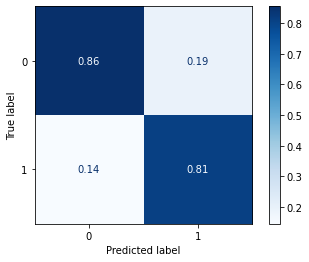

In [113]:
# let's just balance the class weights and see
logreg = LogisticRegression(class_weight = 'balanced')
logreg.fit(X_train_sc, y_train)
preds = logreg.predict(X_test_sc)
evaluation(X_test_sc, y_test, preds, logreg)

balanced_accuracy: 0.8282199004003515
recall: 0.7770334928229665
precision: 0.8063555114200596
f1 score: 0.7914230019493177


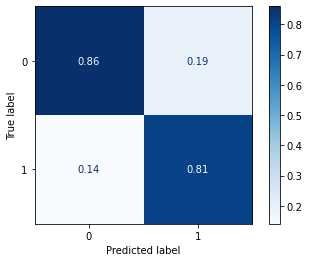

In [114]:
# let's try random undersampling
rus = RandomUnderSampler()
X_train_sc_rus, y_train_rus = rus.fit_resample(X_train_sc, y_train)
logreg = LogisticRegression()
logreg.fit(X_train_sc_rus, y_train_rus)
preds = logreg.predict(X_test_sc)
evaluation(X_test_sc, y_test, preds, logreg)

balanced_accuracy: 0.8150733977801647
recall: 0.8373205741626795
precision: 0.7231404958677686
f1 score: 0.7760532150776053


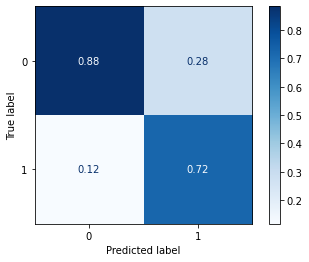

In [115]:
# let's try NearMiss
nm = NearMiss()
X_train_sc_nm, y_train_nm = nm.fit_resample(X_train_sc, y_train)
logreg = LogisticRegression()
logreg.fit(X_train_sc_nm, y_train_nm)
preds = logreg.predict(X_test_sc)
evaluation(X_test_sc, y_test, preds, logreg)

balanced_accuracy: 0.8272043745727956
recall: 0.7712918660287081
precision: 0.8100502512562814
f1 score: 0.7901960784313725


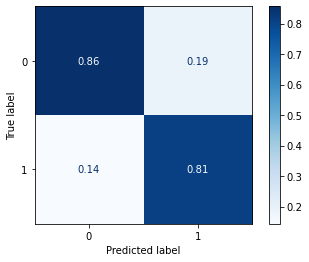

In [116]:
# let's try RandomOverSampler
ros = RandomOverSampler()
X_train_sc_ros, y_train_ros = ros.fit_resample(X_train_sc, y_train)
logreg = LogisticRegression()
logreg.fit(X_train_sc_ros, y_train_ros)
preds = logreg.predict(X_test_sc)
evaluation(X_test_sc, y_test, preds, logreg)

balanced_accuracy: 0.8272043745727956
recall: 0.7712918660287081
precision: 0.8100502512562814
f1 score: 0.7901960784313725


c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
15 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Gabe\anaconda3\lib\site-packages\imblearn\pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Gabe\anaconda3\lib\site-packages\imblearn\pipeline.py", line 226, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "c:\Users\Gabe\anac

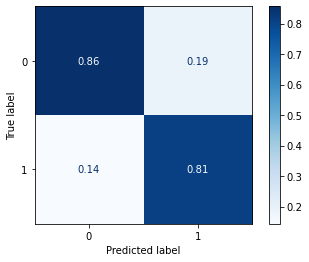

In [117]:
# how about RandomOverSampler with some tuning?
pipe = ImbalancedPipeline([
    ('ros', RandomOverSampler(random_state = 42)),
    ('logr', LogisticRegression(max_iter = 1_000))
])

gs = GridSearchCV(pipe,
    param_grid = { 'ros__sampling_strategy': [0.1, 0.25, 0.5, 0.75, 1.0]}, scoring = 'balanced_accuracy')

gs.fit(X_train_sc, y_train)
preds = gs.predict(X_test_sc)
evaluation(X_test_sc, y_test, preds, gs)

c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
20 fits failed out of a total of 25.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Gabe\anaconda3\lib\site-packages\imblearn\pipeline.py", line 268, in fit
    Xt, yt = self._fit(X, y, **fit_params_steps)
  File "c:\Users\Gabe\anaconda3\lib\site-packages\imblearn\pipeline.py", line 226, in _fit
    X, y, fitted_transformer = fit_resample_one_cached(
  File "c:\Users\Gabe\anac

balanced_accuracy: 0.8393190769130618
recall: 0.815311004784689
precision: 0.7940354147250699
f1 score: 0.8045325779036826


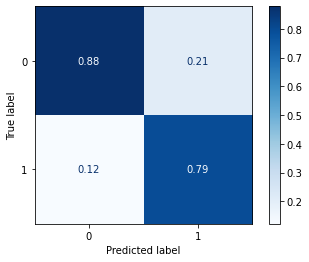

In [118]:
# We'll give it one more shot with ADASYN
pipe = ImbalancedPipeline([
    ('ada', ADASYN(random_state = 42)),
    ('logr', LogisticRegression(max_iter = 1_000))
])

gs = GridSearchCV(pipe,
    param_grid = { 'ada__sampling_strategy': [0.1, 0.25, 0.5, 0.75, 1.0]}, scoring = 'balanced_accuracy')

gs.fit(X_train_sc, y_train)
preds = gs.predict(X_test_sc)
evaluation(X_test_sc, y_test, preds, gs)

CONCLUSIONS
- ADASYN does appear to improve our model slightly, so we will use it to rebalance our target classes

In [119]:
gs.best_estimator_

Pipeline(steps=[('ada', ADASYN(random_state=42, sampling_strategy=1.0)),
                ('logr', LogisticRegression(max_iter=1000))])

In [120]:
adasyn = ADASYN(random_state = 42, sampling_strategy = 1.0)
X_train_sc, y_train = adasyn.fit_resample(X_train_sc, y_train)

CONCLUSIONS
- Now that we've dealt with our class imbalance, we can start trying some other models - we'll use GridSearch for most of these.

In [121]:
# data frame for storing our stats
df_stats = pd.DataFrame(columns = ['model', 'fit_time', 'train_acc', 'test_acc', 'recall', 'precision', 'f1'])

# Thanks to Devin Fay and his Imbalanced Data lesson at GA for the basis of this function
def evaluation(model, model_desc, X_train, y_train, X_test, y_test, normalize = 'pred'):
    '''
    Function to print and acquire some quick model stats.

    Parameters:
        model: the model
        model: description of the model
        X_train, y_train: Training features and target
        X_test, y_test: Testing features and target
        normalize: normalization for ConfusionMatrixDisplay
    Returns:
        Dataframe containing the model, fit time, training accuracy, testing accuracy, recall, precision, and F1
    '''

    start_time = time.time()
    model.fit(X_train, y_train)
    stop_time = time.time()
    fit_time = stop_time - start_time
    preds = model.predict(X_test)
    
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues',
    normalize=normalize)

    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)
    recall = recall_score(y_test, preds, pos_label = 1)
    precision = precision_score(y_test, preds, pos_label = 1)
    f1 = f1_score(y_test, preds, pos_label = 1)
    
    print(f'fit time: {fit_time}')
    print(f'training set accuracy: {train_acc}')
    print(f'test set accuracy: {test_acc}')
    print(f'recall: {recall}')
    print(f'precision: {precision}')
    print(f'f1 score: {f1}')

    return pd.DataFrame([{'model': model_desc, 'fit_time': fit_time, 'train_acc': train_acc, 'test_acc': test_acc,
        'recall': recall, 'precision': precision, 'f1': f1}])

c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
270 fits failed out of a total of 540.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
135 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\Gabe\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 55, in _check_solver
    raise ValueError(
ValueE

fit time: 0.031536102294921875
training set accuracy: 0.8230423226334083
test set accuracy: 0.8474830954169797
recall: 0.8200956937799043
precision: 0.7972093023255814
f1 score: 0.8084905660377358


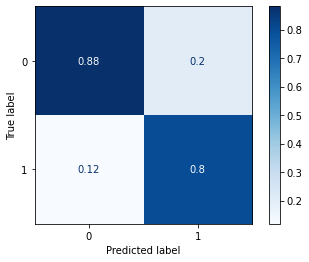

In [122]:
# LogisticRegression (now with tuning)
logreg = LogisticRegression(random_state = 42)
params = {
    'penalty': ['None', 'l1', 'l2', 'elasticnet'],
    'C': [0.1, 1, 10],
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'l1_ratio': [0.1, 0.5, 1.0]
}

gs = GridSearchCV(estimator = logreg, param_grid = params, n_jobs = -1)
gs.fit(X_train_sc, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'Tuned LogisticRegression', X_train_sc, y_train, X_test_sc, y_test)])

fit time: 0.001169443130493164
training set accuracy: 0.9995910856675526
test set accuracy: 0.7956423741547709
recall: 0.7559808612440191
precision: 0.732159406858202
f1 score: 0.7438794726930319


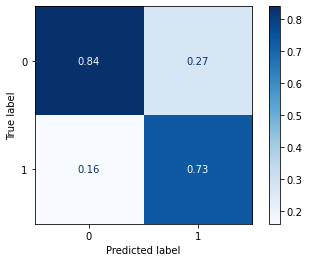

In [123]:
# KNN
knn = KNeighborsClassifier()
params = {
    'n_neighbors': [3, 5, 8],
    'weights': ['uniform', 'distance'],
    'metric': ['minkowski', 'manhattan', 'euclidean']
}

gs = GridSearchCV(estimator = knn, param_grid = params, n_jobs = -1)
gs.fit(X_train_sc, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'KNearestNeighbors', X_train_sc, y_train, X_test_sc, y_test)])

fit time: 0.6277241706848145
training set accuracy: 0.9966264567573093
test set accuracy: 0.8666416228399699
recall: 0.8602870813397129
precision: 0.8113718411552346
f1 score: 0.8351137947050628


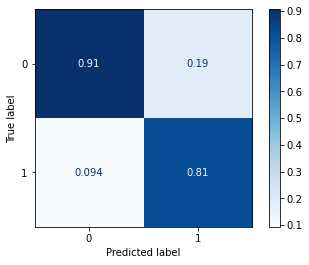

In [124]:
# Bagging
bag = BaggingClassifier(random_state = 42)
params = {
    'n_estimators': [10, 20]
}

gs = GridSearchCV(estimator = bag, param_grid = params, n_jobs = -1)
gs.fit(X_train_sc, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'BaggingClassifier', X_train_sc, y_train, X_test_sc, y_test)])

fit time: 0.800511360168457
training set accuracy: 0.9106522183602536
test set accuracy: 0.8677685950413223
recall: 0.938755980861244
precision: 0.7730496453900709
f1 score: 0.8478824546240278


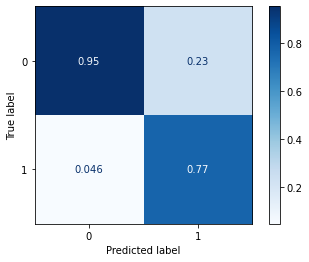

In [125]:
# Random Forest
rf = RandomForestClassifier(random_state = 42)
params = {
    'n_estimators': [100, 150],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [2, 5, 10],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

gs = GridSearchCV(estimator = rf, param_grid = params, n_jobs = -1)
gs.fit(X_train_sc, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'RandomForestClassifier', X_train_sc, y_train, X_test_sc, y_test)])

fit time: 0.38355588912963867
training set accuracy: 0.8839705581680638
test set accuracy: 0.8613824192336589
recall: 0.9282296650717703
precision: 0.7674050632911392
f1 score: 0.8401905586834126


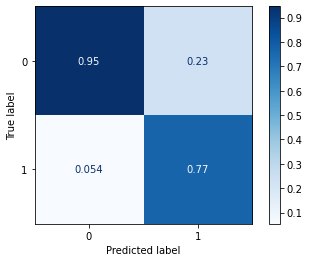

In [126]:
# AdaBoost
ada = AdaBoostClassifier(random_state = 42)
params = {
    'n_estimators': [50, 100],
    'learning_rate': [1, 5, 10]
}

gs = GridSearchCV(estimator = ada, param_grid = params, n_jobs = -1)
gs.fit(X_train_sc, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'AdaBoostClassifier', X_train_sc, y_train, X_test_sc, y_test)])

fit time: 0.7518014907836914
training set accuracy: 0.9262931915763648
test set accuracy: 0.877160030052592
recall: 0.9090909090909091
precision: 0.8037225042301185
f1 score: 0.8531656937584194


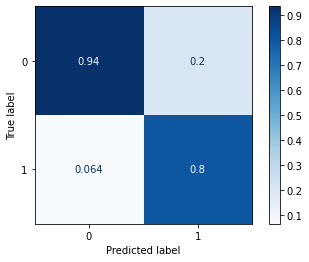

In [127]:
# GradientBoost
grad = GradientBoostingClassifier(random_state = 42)
params = {
    'n_estimators': [100, 150],
    'subsample': [0.7, 1.0],
    'learning_rate': [0.1, 1, 10],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]
}

gs = GridSearchCV(estimator = grad, param_grid = params, n_jobs = -1)
gs.fit(X_train_sc, y_train)
df_stats = pd.concat([df_stats, evaluation(gs.best_estimator_, 'GradientBoostingClassifier', X_train_sc, y_train, X_test_sc, y_test)])

84/84 [==============================] - 0s 1ms/step
training set accuracy: 0.8642404675483704
test set accuracy: 0.8523666262626648
recall: 0.9416267942583733
precision: 0.7477203647416414
f1 score: 0.8335451080050826


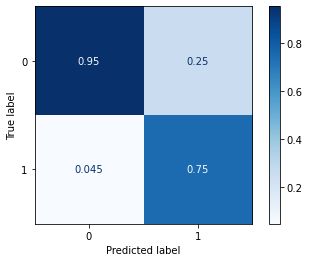

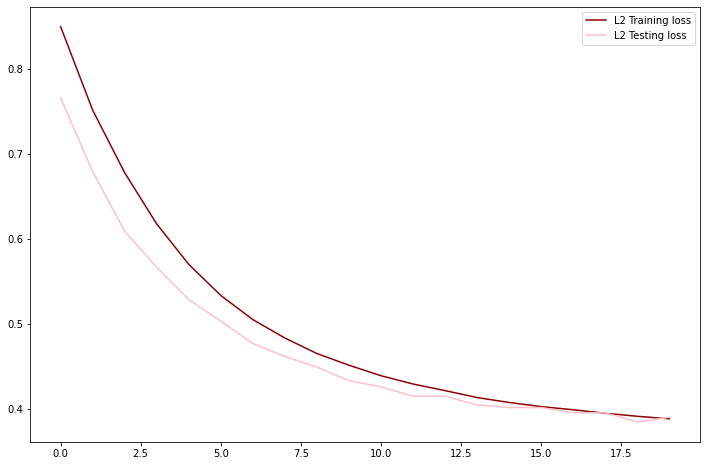

In [128]:
# L2-regularized FNN
# Model
model = Sequential()
model.add(Dense(units = 32, activation = 'relu', input_shape = (32, ),
    kernel_regularizer = l2(0.005)))
model.add(Dense(units = 16, activation = 'relu', kernel_regularizer = l2(0.005)))
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compile it
model.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc'])

# Fit it
res = model.fit(x = X_train_sc, y = y_train, validation_data = (X_test_sc, y_test),
    epochs = 20, batch_size = 256, verbose = 0)

# Scores
train_acc = res.history['acc'][-1]
test_acc = res.history['val_acc'][-1]
preds = pd.Series(model.predict(X_test_sc)[:, 0]).map(lambda x: 1 if x >= 0.5 else 0)
recall = recall_score(y_test, preds, pos_label = 1)
precision = precision_score(y_test, preds, pos_label = 1)
f1 = f1_score(y_test, preds, pos_label = 1)
print(f'training set accuracy: {train_acc}')
print(f'test set accuracy: {test_acc}')
print(f'recall: {recall}')
print(f'precision: {precision}')
print(f'f1 score: {f1}')

ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize = 'pred', cmap='Blues')

# Visualize
train_loss_l2 = res.history['loss']
test_loss_l2 = res.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss_l2, label='L2 Training loss', color='darkred')
plt.plot(test_loss_l2, label='L2 Testing loss', color='pink')
plt.legend();

84/84 [==============================] - 0s 1ms/step
training set accuracy: 0.8509507179260254
test set accuracy: 0.8519909977912903
recall: 0.9511961722488038
precision: 0.743455497382199
f1 score: 0.834592779177162


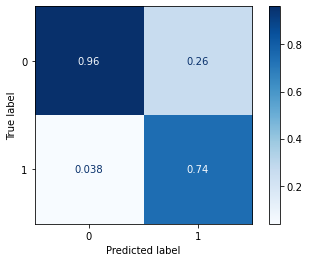

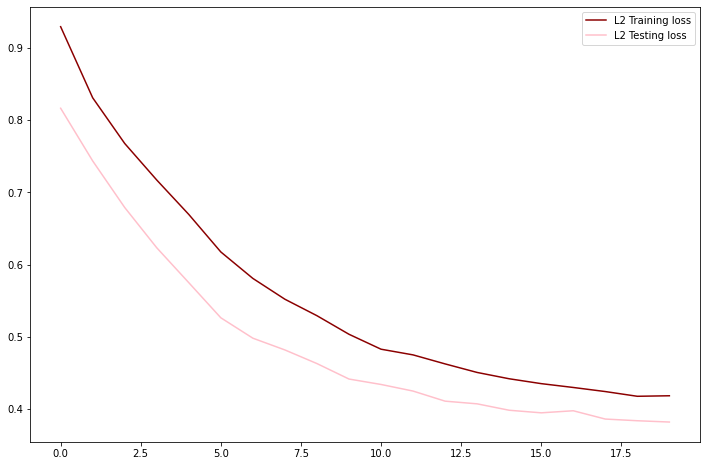

In [129]:
# Add dropouts
# Model
model = Sequential()
model.add(Dense(units = 32, activation = 'relu', input_shape = (32, ), kernel_regularizer = l2(0.005)))
model.add(Dropout(rate = 0.3))
model.add(Dense(units = 16, activation = 'relu', kernel_regularizer = l2(0.005)))
model.add(Dropout(rate = 0.3))
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compile it
model.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc'])

# Fit it
res = model.fit(x = X_train_sc, y = y_train, validation_data = (X_test_sc, y_test),
    epochs = 20, batch_size = 256, verbose = 0)

# Scores
train_acc = res.history['acc'][-1]
test_acc = res.history['val_acc'][-1]
preds = pd.Series(model.predict(X_test_sc)[:, 0]).map(lambda x: 1 if x >= 0.5 else 0)
recall = recall_score(y_test, preds, pos_label = 1)
precision = precision_score(y_test, preds, pos_label = 1)
f1 = f1_score(y_test, preds, pos_label = 1)
print(f'training set accuracy: {train_acc}')
print(f'test set accuracy: {test_acc}')
print(f'recall: {recall}')
print(f'precision: {precision}')
print(f'f1 score: {f1}')

ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize = 'pred', cmap='Blues')

# Visualize
train_loss_l2 = res.history['loss']
test_loss_l2 = res.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss_l2, label='L2 Training loss', color='darkred')
plt.plot(test_loss_l2, label='L2 Testing loss', color='pink')
plt.legend();

84/84 [==============================] - 0s 1ms/step
training set accuracy: 0.8767123222351074
test set accuracy: 0.8621337413787842
recall: 0.9339712918660287
precision: 0.7660910518053375
f1 score: 0.8417421302285467


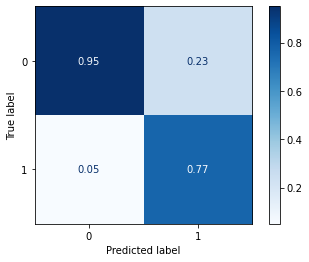

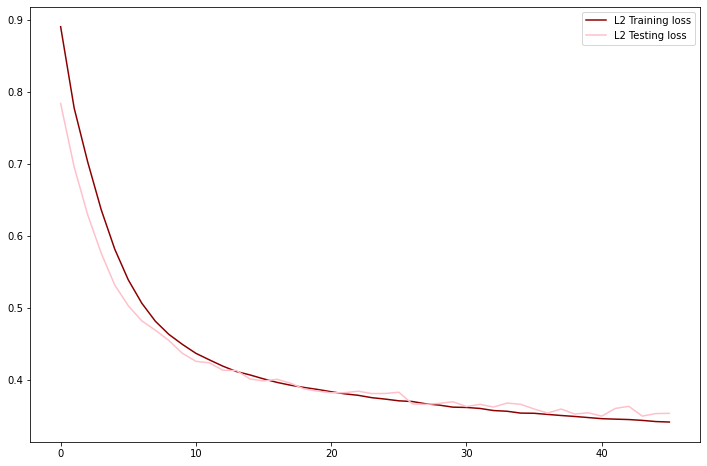

In [130]:
# L2-regularized FNN with early stopping
es = EarlyStopping(patience = 5)

# Model
model = Sequential()
model.add(Dense(units = 32, activation = 'relu', input_shape = (32, ),
    kernel_regularizer = l2(0.005)))
model.add(Dense(units = 16, activation = 'relu', kernel_regularizer = l2(0.005)))
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compile it
model.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc'])

# Fit it
res = model.fit(x = X_train_sc, y = y_train, validation_data = (X_test_sc, y_test),
    epochs = 100, batch_size = 256, verbose = 0, callbacks = [es])

# Scores
train_acc = res.history['acc'][-1]
test_acc = res.history['val_acc'][-1]
preds = pd.Series(model.predict(X_test_sc)[:, 0]).map(lambda x: 1 if x >= 0.5 else 0)
recall = recall_score(y_test, preds, pos_label = 1)
precision = precision_score(y_test, preds, pos_label = 1)
f1 = f1_score(y_test, preds, pos_label = 1)
print(f'training set accuracy: {train_acc}')
print(f'test set accuracy: {test_acc}')
print(f'recall: {recall}')
print(f'precision: {precision}')
print(f'f1 score: {f1}')

ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize = 'pred', cmap='Blues')

# Visualize
train_loss_l2 = res.history['loss']
test_loss_l2 = res.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss_l2, label='L2 Training loss', color='darkred')
plt.plot(test_loss_l2, label='L2 Testing loss', color='pink')
plt.legend();

84/84 [==============================] - 0s 1ms/step
training set accuracy: 0.8797791600227356
test set accuracy: 0.8651390075683594
recall: 0.9339712918660287
precision: 0.7709320695102686
f1 score: 0.8446559930765902


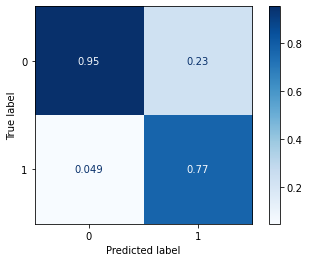

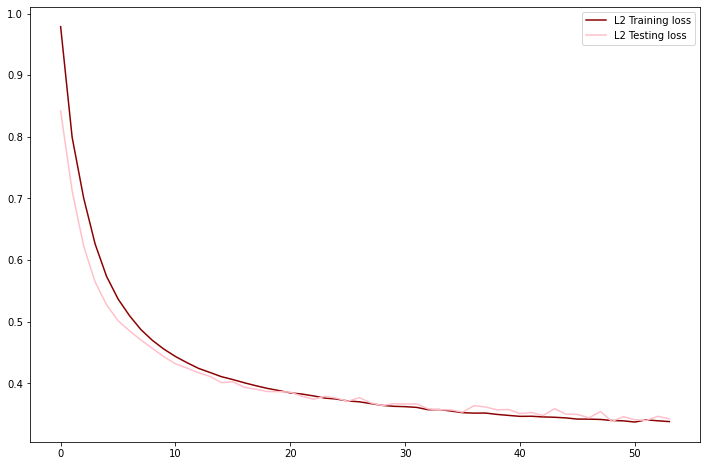

In [131]:
# PCA on the front end
pca = PCA(random_state = 42)
X_train_sc = pca.fit_transform(X_train_sc)
X_test_sc = pca.transform(X_test_sc)

# L2-regularized FNN with early stopping
es = EarlyStopping(patience = 5)

# Model
model = Sequential()
model.add(Dense(units = 32, activation = 'relu', input_shape = (32, ),
    kernel_regularizer = l2(0.005)))
model.add(Dense(units = 16, activation = 'relu', kernel_regularizer = l2(0.005)))
model.add(Dense(units = 1, activation = 'sigmoid'))

# Compile it
model.compile(optimizer = 'adam', loss = 'bce', metrics = ['acc'])

# Fit it
res = model.fit(x = X_train_sc, y = y_train, validation_data = (X_test_sc, y_test),
    epochs = 100, batch_size = 256, verbose = 0, callbacks = [es])

# Scores
train_acc = res.history['acc'][-1]
test_acc = res.history['val_acc'][-1]
preds = pd.Series(model.predict(X_test_sc)[:, 0]).map(lambda x: 1 if x >= 0.5 else 0)
recall = recall_score(y_test, preds, pos_label = 1)
precision = precision_score(y_test, preds, pos_label = 1)
f1 = f1_score(y_test, preds, pos_label = 1)
print(f'training set accuracy: {train_acc}')
print(f'test set accuracy: {test_acc}')
print(f'recall: {recall}')
print(f'precision: {precision}')
print(f'f1 score: {f1}')

ConfusionMatrixDisplay.from_predictions(y_test, preds, normalize = 'pred', cmap='Blues')

# Visualize
train_loss_l2 = res.history['loss']
test_loss_l2 = res.history['val_loss']

plt.figure(figsize=(12, 8))
plt.plot(train_loss_l2, label='L2 Training loss', color='darkred')
plt.plot(test_loss_l2, label='L2 Testing loss', color='pink')
plt.legend();

CONCLUSIONS
- It looks like an L2-regularized neural network with early stopping (around 62 epochs or so) gives us the best combination of high accuracy and low variance.
- The recall, precision and F1 for this model are also in keeping with, or better than, the other models.
- This will be our production model for Florida.

**Model 3: Behavioral feature set - Georgia**

**FINAL NOTES**
- The model statistics are exported [here](../data/model_stats.csv).
- The next notebook in the series is [Model Tuning](./04_tuning.ipynb).